## Autograd
- autograd 패키지는 텐서의 모든 연산에 대한 자동 미분을 제공
- 실행 기반 정의(define-by-run) 패키지로, 코드를 어떻게 작성하여 실행하느냐에  따라 역전파가 정의된다
- 역전파는 학습의 매 단계마다 달라진다.

## Tensor
- `torch.Tensor` 클래스의 `.requires_grad` 속성을 `True`로 설정하면, 해당 텐서에서 이루어지는 모든 연산을 추적하기 시작
- 계산이 완료된 후 `backward()`를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있으며 이 tensor의 변화도는 `.grad` 속성에 누적된다.
- Tensor가 기록을 추적하는 것을 중단하게 하려면, `.detach()`를 호출하여 연산기록으로 부터 분리하여 연산이 추적되는 것을 방지할 수 있다.
- 기록을 추적하는것(과 메모리를 사용하는것)을 방지하기 위하여 코드 블럭을 `with torch.no_grad`로 감쌀 수 있다.
- 이는 변화도(gradient)는 필요 없지만, `requires_grad-True` 가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가할 때 유용하다.
- `Audograd` 구현에서 `Function` 클래스는 매우 중요한 역할을 수행한다.
- `Tensor`와 `Function`은 서로 연결되어 있고 모든 연산 과정을 부호화하여 순환하지 않는 그래프를 생성한다.
- 각 `tensor`는 `.grad._fn` 속성을 가지고 있는데, 이는 `Tensor`를 생성한 `Function`을 참조한다.( 단, 사용하자 만든 `Tensor`는 예외이며, 사용자가 만든 `Tensor`가 아닌 연산에 의해서 생긴 텐서와 같은 경우에는 모두 `Function`을 참조)
- 도함수를 계산하기 위해서는 `Tensor`의 `.backward`를 호출하면 된다.


In [ ]:
import torch

torch.__version__

'1.10.0+cu111'

In [ ]:
# x의 연산 과적을 추적하귀 위해 requires_grad=True로 설정

x = torch.ones(2, 2, requires_grad=True)
print(x)

# 직접 생산한 Tensor이기 때문에 grad_fn이 None으로 설정되었음을 확인할 수 있다.
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [ ]:
# y는 연산의 결과로 생성된 것이기 때문에 grad_fn을 가지고 있는것을 확인할 수 있다.

y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [ ]:
z = y * y * 3
out = z.mean()

# 각각 사용한 func에 맞게 grad_fn이 생성된 것을 확인할 수 있다.
z, out

(tensor([[27., 27.],
         [27., 27.]], grad_fn=<MulBackward0>),
 tensor(27., grad_fn=<MeanBackward0>))

- `requires_grad()`를 사용하면 기존 Tensor의 requires_grad값을 변경할 수 있다.
- 입력값이 지정되지 않으면 기본값은 False

In [ ]:
a = torch.randn(2, 2)
a

tensor([[ 0.0910, -0.2396],
        [-0.6218,  0.2738]])

In [ ]:
a = (a * 3) / (a - 1)
print(a)
print(a.requires_grad)

tensor([[-0.3005,  0.5798],
        [ 1.1502, -1.1308]])
False


In [ ]:
a.requires_grad_ = True
a.requires_grad

False

In [ ]:
b = (a*a).sum()
print(b)
print(b.requires_grad)

tensor(3.0282)
False


## 변화도(Gradient)

In [ ]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행

# 중간값에 대한 미분값을 보고 싶다면 해당 값에 대한 retain_grad()를 호출해야 한다.
y.retain_grad()
z.retain_grad()

# 여러번 미분을 수행하기 위해서는 retain_graph=True로 설정해줘야 한다.
out.backward() 

# out.backward(torch.tensor(1.0))을 진행하는 것과 동일
print(x.grad)
print(y.grad)
print(z.grad)
print(z.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])
False


RuntimeError: ignored

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

print(out)

y.retain_grad()
out.backward(retain_graph=True)

print(x.grad)
print(y.grad)
print(z.grad) # z.retain_grad()를 호출하지 않으면 grad값을 저장하지 않기 때문에 grad 속성을 볼 수 없다.
print(z.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
False
tensor([[9., 9.],
        [9., 9.]])
tensor([[9., 9.],
        [9., 9.]])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


- 일반적으로 `torch.autograd`는 벡터-야코비안 곱을 계산하는 엔진
- torch.autograd를 사용하면 전체 야코비안을 직접 계산할 수는 없지만, 벡터-야코비안 곱은 backward에 해당 벡터를 인자로 제공하여 얻을 수 있다.

In [ ]:
x = torch.randn(3, requires_grad=True)

y = x + 2

while y.data.norm() < 1000:
  y = y * 2

print(y)

tensor([-165.6401,  472.9279, 1167.4133], grad_fn=<MulBackward0>)


In [ ]:
# scalar값이 아닌 y의 벡터 야코비안 곱을 구하는 과정

v = torch.tensor([0.1, 1.0, 0.001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([ 51.2000, 512.0000,   0.5120])


- with torch.no_grad()로 코드 블럭을 감싸서 autograd가 .requires_grad=True 인 Tensor의 연산 기록을 추적하는 것을 멈출 수 있다.

In [ ]:
print(x.requires_grad)
print((x**2).requires_grad)

with torch.no_grad():
  print((x**2).requires_grad)

True
True
False


- 또는 .detach()를 호출하여 내용은 같지만 requires_grad가 다른 새로운 텐서를 가져올 수 있다.



In [ ]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
x.eq(y).all()

True
False


tensor(True)

## ANN(Artificial Neural Networks)
- 신경망은 torch.nn 패키지를 사용하여 생성할 수 있다.
- nn 모델을 정의하고 미분하기 위해서 위에서 살펴본 autograd를 사용
- nn.Moduled은 계층(layer)과 output을 반환하는 forward(input) 메소드를 포함

- 간단한 순전파 네트워크(feed-forward-network)
- 입력을 받아 여러 계층에 전달한 후 최종 출력을 제공
- 신경망의 일반적인 학습 과정
  - 학습 가능한 매개변수(가중치)를 갖는 신경망을 정의
  - 데이터 셋 입력을 반복
  - 입력을 신경망에서 전파
  - 손실을 계산
  - 변화도(gradient)를 신경망의 매개변수들에 역전파
  - 신경망의 가중치를 갱신
    - `새로운 가중치(weight) = 가중치(weight) - 학습률(learning_rate) * 변화도(gradient)`

In [21]:
import pandas as pd
from sklearn.datasets import load_iris
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [22]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.layer0 = nn.Linear(4, 128)
    self.layer1 = nn.Linear(128, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 16)
    self.layer4 = nn.Linear(16, 3)

    self.bn0 = nn.BatchNorm1d(128)
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(32)

    self.act = nn.ReLU()
  
  def forward(self, x):
    x = self.act(self.bn0(self.layer0(x)))
    x = self.act(self.bn1(self.layer1(x)))
    x = self.act(self.bn2(self.layer2(x)))
    x = self.act(self.layer3(x))
    x = self.layer4(x)

    return x

## 손실함수(Loss Function)
- 손실함수는 (output, target)값을 한 쌍으로 입력 받아, 출력이 정답으로 부터 얼마나 떨어져 있는지를 추정하는 값을 계산한다.
- forward 함수만 정의하고나면 backward 함수는 autograd를 사용하여 자동으로 정의가 된다.
- 모델의 학습 가능한 매개 변수는 `net.parameters()`에 의해 변환된다.

In [32]:
# 랜덤 값 생성
criterion = nn.CrossEntropyLoss()

ex_X, ex_y = torch.randn([4, 4]), torch.tensor([1, 0, 2, 0])

net = Net()
output = net(ex_X)
loss = criterion(output, ex_y)
print('loss:', loss.item())

net.zero_grad()

print('layer4.bias.grad before backward')
print(net.layer4.bias.grad)

print(net.layer4.bias.is_leaf)

loss.backward()

print('layer4.bias.grad after backward')
print(net.layer4.bias.grad)

loss: 1.213205099105835
layer0.bias.grad before backward
None
True
layer0.bias.grad after backward
tensor([-0.2056,  0.0956,  0.1100])


In [34]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # layer0의 weight

16
torch.Size([128, 4])


## 가중치 갱신
- 가장 단순한 갱신 규칙은 확률적 경사 하강법(SGD)
- `새로운 가중치 = 가중치weight) - 학습률(learning_rate) * 변화도(gradient)`

In [36]:
# torch.optim 패키지에 다양한 갱신 규칙들이 구현되어 있다.

import torch.optim as optim

optimizer =optim.SGD(net.parameters(), lr=0.001)

optimizer.zero_grad()
output = net(ex_X)
loss = criterion(output, ex_y)
loss.backward()
optimizer.step() # 가중치 업데이트 진행

## MLP 모델

In [38]:
dataset = load_iris()

data = dataset.data
label = dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
X_train.shape, X_test.shape

((112, 4), (38, 4))

In [49]:
#DataLoader 생성

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_set = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [50]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.layer0 = nn.Linear(4, 128)
    self.layer1 = nn.Linear(128, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 16)
    self.layer4 = nn.Linear(16, 3)

    self.bn0 = nn.BatchNorm1d(128)
    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(32)

    self.act = nn.ReLU()
  
  def forward(self, x):
    x = self.act(self.bn0(self.layer0(x)))
    x = self.act(self.bn1(self.layer1(x)))
    x = self.act(self.bn2(self.layer2(x)))
    x = self.act(self.layer3(x))
    x = self.layer4(x)

    return x

In [51]:
net = Net()
print(net)

Net(
  (layer0): Linear(in_features=4, out_features=128, bias=True)
  (layer1): Linear(in_features=128, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=3, bias=True)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [52]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 200

In [55]:
losses = list()
accuracies = list()

for epoch in range(epochs):
  epoch_loss = 0
  epoch_accuracy = 0

  for X, y in train_loader:
    optimizer.zero_grad() # grad값 초기화

    output = net(X)

    loss = criterion(output, y)
    loss.backward() # 오류역전파 수행

    optimizer.step() # 가중치 업데이트
    
    # output = [0.1, 0.5, 0.8] --> 예측 클래스 값
    _, predicted = torch.max(output, dim=1)
    accuracy = (predicted == y).sum().item()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy

  epoch_loss /= len(train_loader)
  epoch_accuracy /= len(X_train)
  print('epoch :{}, \tloss :{}, \taccuracy :{}'.format(str(epoch+1).zfill(3), round(epoch_loss, 4), round(epoch_accuracy, 4)))

  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)



epoch :001, 	loss :0.3635, 	accuracy :0.8661
epoch :002, 	loss :0.4209, 	accuracy :0.8125
epoch :003, 	loss :0.4186, 	accuracy :0.8304
epoch :004, 	loss :0.5083, 	accuracy :0.7857
epoch :005, 	loss :0.4782, 	accuracy :0.8036
epoch :006, 	loss :0.4077, 	accuracy :0.8571
epoch :007, 	loss :0.3187, 	accuracy :0.9018
epoch :008, 	loss :0.4415, 	accuracy :0.8393
epoch :009, 	loss :0.3973, 	accuracy :0.8482
epoch :010, 	loss :0.4658, 	accuracy :0.8304
epoch :011, 	loss :0.3866, 	accuracy :0.8661
epoch :012, 	loss :0.5102, 	accuracy :0.8036
epoch :013, 	loss :0.457, 	accuracy :0.7768
epoch :014, 	loss :0.3802, 	accuracy :0.875
epoch :015, 	loss :0.3644, 	accuracy :0.8839
epoch :016, 	loss :0.3441, 	accuracy :0.875
epoch :017, 	loss :0.465, 	accuracy :0.8036
epoch :018, 	loss :0.5581, 	accuracy :0.7679
epoch :019, 	loss :0.3486, 	accuracy :0.8661
epoch :020, 	loss :0.4555, 	accuracy :0.7768
epoch :021, 	loss :0.4024, 	accuracy :0.8214
epoch :022, 	loss :0.5026, 	accuracy :0.8125
epoch :023, 	l

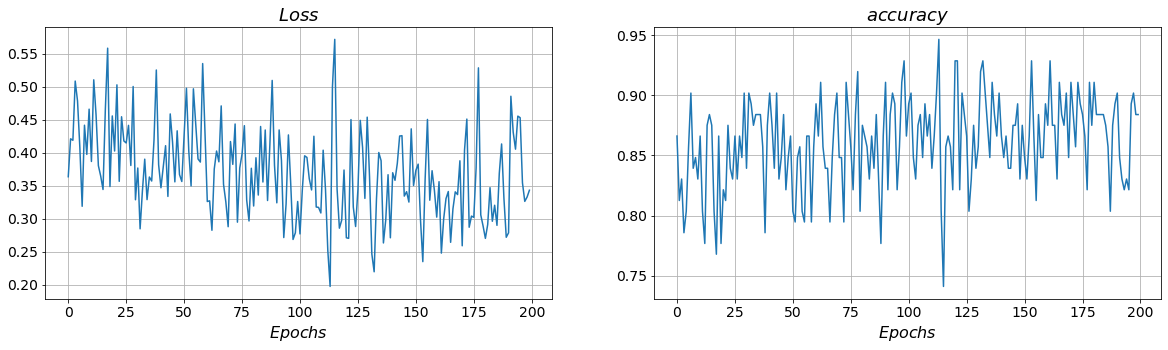

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.title('$Loss$', fontsize=18)
plt.plot(losses)
plt.grid()
plt.xlabel('$Epochs$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.title('$accuracy$', fontsize=18)
plt.plot(accuracies)
plt.grid()
plt.xlabel('$Epochs$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [73]:
# Test

output = net(X_test)
print(torch.max(output, dim=1))
_, predicted = torch.max(output, dim=1)
accuracy = round((predicted == y_test).sum().item() / len(y_test), 4)

print('test_set_accuracy: ', round(accuracy, 4))

torch.return_types.max(
values=tensor([2.6525, 1.5210, 2.1009, 2.9778, 3.1515, 1.4679, 1.8967, 1.9802, 2.1478,
        2.8087, 5.7294, 2.8138, 1.5024, 4.9334, 1.7573, 1.5563, 3.9233, 3.8885,
        2.8584, 1.2433, 2.7851, 2.9996, 4.9927, 1.9415, 2.3389, 3.2491, 0.9987,
        3.6929, 2.6654, 2.9560, 2.5689, 2.2511, 1.3794, 1.9115, 2.3302, 1.7259,
        0.7375, 2.8981], grad_fn=<MaxBackward0>),
indices=tensor([0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 0, 0, 2,
        2, 0, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2]))
test_set_accuracy:  0.9474
